# Spectral Analysis

## Preparations

In [1]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



In [2]:
# Import data

df = pd.read_csv('merged_cleaned.csv', names=["time", "load", "price", "biomass", "water", "offshore", "onshore", "solar", "other_renewable", "nuclear", "lignite", "coal", "gas", "pumped", "other_conv", "holiday", "date", "hour", "dayofweek", "day_name", "quarter", "month", "year", "dayofyear", "dayofmonth", "date_offset", "hour_sin", "hour_cos", "dayofweek_sin", "dayofweek_cos", "month_sin", "month_cos", "dayofyear_sin", "dayofyear_cos", "is_workday"], header=0)

# Adapt column "holiday", so only 0 for Not a Holiday and 1 for any holidays is used
df["holiday"] = df["holiday"].apply(lambda x: 0 if x == "Not a Holiday" else 1)

# Convert 'time' to datetime and set as index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Inspect the first few rows of the data
print(df.head())

                         load  price  biomass    water  offshore   onshore  \
time                                                                         
2018-11-01 00:00:00  48879.50  40.86  4754.75  1583.00   2721.00  11628.50   
2018-11-01 01:00:00  47312.50  41.10  4741.25  1587.50   2678.00  11029.00   
2018-11-01 02:00:00  46093.75  40.59  4733.25  1567.50   2836.75  11025.00   
2018-11-01 03:00:00  46710.50  40.09  4725.25  1550.00   2968.50  10480.25   
2018-11-01 04:00:00  47624.25  39.11  4715.00  1535.75   2765.25  10871.25   

                     solar  other_renewable  nuclear   lignite  ...  \
time                                                            ...   
2018-11-01 00:00:00    0.0           153.00   7933.0  16108.75  ...   
2018-11-01 01:00:00    0.0           153.00   7933.5  16119.00  ...   
2018-11-01 02:00:00    0.0           153.00   7927.0  16111.00  ...   
2018-11-01 03:00:00    0.0           152.50   7930.5  16134.75  ...   
2018-11-01 04:00:00    0.0 

## Normalize time series

Following code was used to normalize the Time Series. Since the results were worse with normalized data compared to identical experiments with the original data, we continued without using the normalization.

If you want to use it, remove the comments from the code.

In [3]:

#mean = df['load'].mean()
#std = df['load'].std()
#df['load'] = (df['load'] - mean) / std

## Train / Test split

In [3]:
# Check for the range of the data to verify the time span
# It should show the range from November 1st 2018 to October 31st 2024
print(df.index.min(), df.index.max())

# Split the data into training and test sets (5:1 years)
train_size = int(0.83296 * len(df))
train, test = df.iloc[:train_size], df.iloc[train_size:]


2018-11-01 00:00:00 2024-10-30 23:00:00


## Fourier Transform

We start the spectral analysis by performing FFT.

In [4]:
from numpy.fft import fft, fftfreq

# Perform FFT on "load" column
energy_load = train['load']  
n = len(energy_load)
spectrum = np.fft.fft(energy_load)
freqs = fftfreq(n, d=1)  # Adjust d for the time difference between entries (1 for hourly data)
phases = np.angle(spectrum)
amplitudes = np.abs(spectrum)


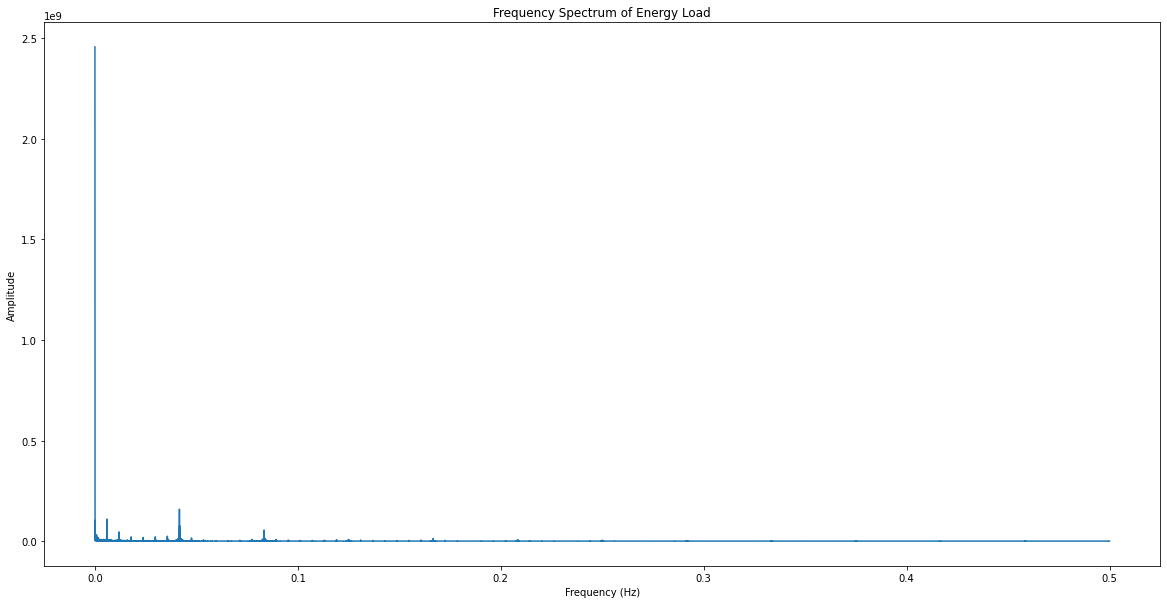

In [5]:
# Plot the amplitude spectrum
plt.figure(figsize=(20, 10))
plt.plot(freqs[:n // 2], np.abs(spectrum)[:n // 2])  # Only plot positive frequencies
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum of Energy Load')
plt.show()

The highest peak is just above 0.0 Hz. Some more peaks are following until just below 0.1 Hz. After this, the plot is a mainly flat line, with only a few small peaks until 0.3 Hz.

For further analysis, we remove the peaks at around 0.0 Hertz and only keep values over 0.00015 Hertz. 

We also want to remove the higher frequencies with very low amplitudes. In a first attempt, we removed frequencies over 0.1 Hz. This did not yoeld very good results in the following experiments, so we adjusted the threshold to 0.3 Hz.

c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


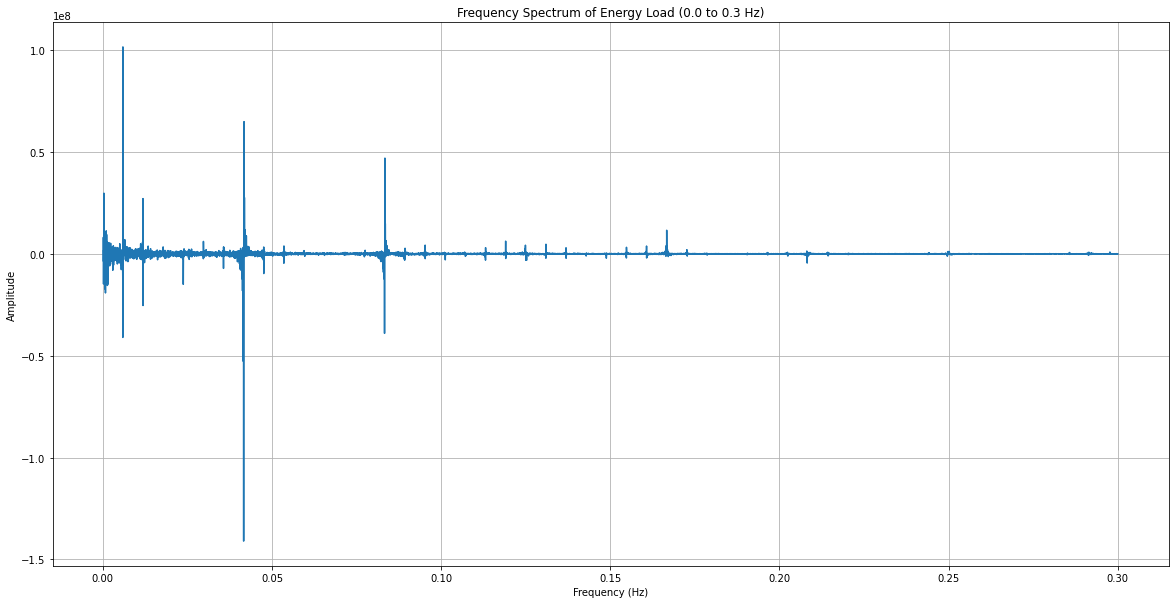

In [6]:
# Filter frequencies and spectrum for the range >0.00015 to 0.1 Hz
freq_range = (freqs > 0.00015) & (freqs <= 0.3)  # Frequency mask for the range from 0.0 to 0.1 Hz

# Apply the mask to both freqs and spectrum
filtered_freqs = freqs[freq_range]
filtered_spectrum = spectrum[freq_range]

# Plot the filtered frequency spectrum
plt.figure(figsize=(20, 10))
plt.plot(filtered_freqs, filtered_spectrum)  # Plot only the filtered frequencies
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum of Energy Load (0.0 to 0.3 Hz)')
plt.grid(True)
plt.show()

The new plot of the filtered data shows several very clear peaks in an otherwise flat line.

## Top frequencies

Let's have a look at the 15 frequencies with the highest amplitudes:

<b> Attention: This way to calculate the highest amplitude uses the complex value. There is another method to only use the absolute values of the amplitudes  to rank the frequencies (see below). </b>

In [8]:
# Get the top 15 frequencies, their amplitudes and phases

# Get the top 15 indices of the highest amplitudes
top_indices = np.argsort(filtered_spectrum)[-15:]
# Get the top frequencies
top_freqs = filtered_freqs[top_indices]
# Get the amplitude of the top frequencies
top_amplitudes = np.abs(filtered_spectrum[top_indices])
# Get the phase of the top frequencies
top_phases = np.angle(filtered_spectrum[top_indices])


# Print the 15 frequencies with the highest amplitudes and their corresponding periods
print("Top 15 frequencies with highest amplitudes (in Hz) and their periods (in hours):")
for freq, amp in zip(top_freqs, top_amplitudes):
    period = 1 / freq  # Calculate the period (in hours) for each frequency
    print(f"Frequency: {freq:.4f} Hz, Amplitude: {amp:.4f}, Period: {period:.2f} hours")

Top 15 frequencies with highest amplitudes (in Hz) and their periods (in hours):
Frequency: 0.0011 Hz, Amplitude: 12524896.6249, Period: 876.60 hours
Frequency: 0.0060 Hz, Amplitude: 12453402.2761, Period: 166.02 hours
Frequency: 0.0421 Hz, Amplitude: 13650936.1647, Period: 23.76 hours
Frequency: 0.0010 Hz, Amplitude: 15134784.8026, Period: 974.00 hours
Frequency: 0.1667 Hz, Amplitude: 12425784.7357, Period: 6.00 hours
Frequency: 0.0420 Hz, Amplitude: 15486916.4671, Period: 23.82 hours
Frequency: 0.0060 Hz, Amplitude: 16758675.6598, Period: 166.65 hours
Frequency: 0.0835 Hz, Amplitude: 16135277.5539, Period: 11.98 hours
Frequency: 0.0060 Hz, Amplitude: 26652552.9560, Period: 167.29 hours
Frequency: 0.0119 Hz, Amplitude: 45708119.8908, Period: 84.13 hours
Frequency: 0.0419 Hz, Amplitude: 31264744.8986, Period: 23.89 hours
Frequency: 0.0003 Hz, Amplitude: 29818615.4611, Period: 2922.00 hours
Frequency: 0.0834 Hz, Amplitude: 54650681.6576, Period: 11.99 hours
Frequency: 0.0418 Hz, Amplitu

Those frequencies represent the seasonalities in the dataset. The hourly values represent following time periods:

- 6 hours => 6 hours
- 12 hours => day/night
- 24 hours => a day
- 84 hours => 3.5 days / half a week
- 168 hours => 7 days / a week
- 876 hours => 36 days
- 974 hours => 41 days
- 2922 hours => 122 days / 4 months

Some of the time periods occurr several times with slightly different frequencies, for example 23,76, 23,82, 23.89 and 23.95 hours, which all represent one day. Those frequencies are quite dominating in the dataset, which shows there is a very strong seasonality on a few primary periods.


Before we filtered the data and removed frequencies under 0.00015 Hz, the highest amplitude was for a period of "infinite hours", which means no oscillation / a static value. This  represented noise and was removed by the filter.

## Represent the top frequencies as sine waves

Our dataset has some strong seasonalities. We want to use this to represent the data as sine waves, trying to approximate the actual data with a combination of those sine waves.

We use the top 10 frequencies for this. 

We include the frequency, amplitude and phase of each frequency to the calculation of the sine wave.

We also sum up those sine waves to see, what their combination is like.

In [9]:
# Build sine waves to represent the top 10 frequencies:

df['sin_1'] = top_amplitudes[0] * np.sin(2 * np.pi * top_freqs[0] * np.arange(len(df)) + top_phases[0])
df['sin_2'] = top_amplitudes[1] * np.sin(2 * np.pi * top_freqs[1] * np.arange(len(df)) + top_phases[1])
df['sin_3'] = top_amplitudes[2] * np.sin(2 * np.pi * top_freqs[2] * np.arange(len(df)) + top_phases[2])
df['sin_4'] = top_amplitudes[3] * np.sin(2 * np.pi * top_freqs[3] * np.arange(len(df)) + top_phases[3])
df['sin_5'] = top_amplitudes[4] * np.sin(2 * np.pi * top_freqs[4] * np.arange(len(df)) + top_phases[4])
df['sin_6'] = top_amplitudes[5] * np.sin(2 * np.pi * top_freqs[5] * np.arange(len(df)) + top_phases[5])
df['sin_7'] = top_amplitudes[6] * np.sin(2 * np.pi * top_freqs[6] * np.arange(len(df)) + top_phases[6])
df['sin_8'] = top_amplitudes[7] * np.sin(2 * np.pi * top_freqs[7] * np.arange(len(df)) + top_phases[7])
df['sin_9'] = top_amplitudes[8] * np.sin(2 * np.pi * top_freqs[8] * np.arange(len(df)) + top_phases[8])
df['sin_10'] = top_amplitudes[9] * np.sin(2 * np.pi * top_freqs[9] * np.arange(len(df)) + top_phases[9])

In [10]:
# Combine the sine waves by summing them up.

df['combined_sin'] = df[['sin_1', 'sin_2', 'sin_3', 'sin_4', 'sin_5', 'sin_6', 'sin_7', 'sin_8', 'sin_9', 'sin_10']].sum(axis=1)

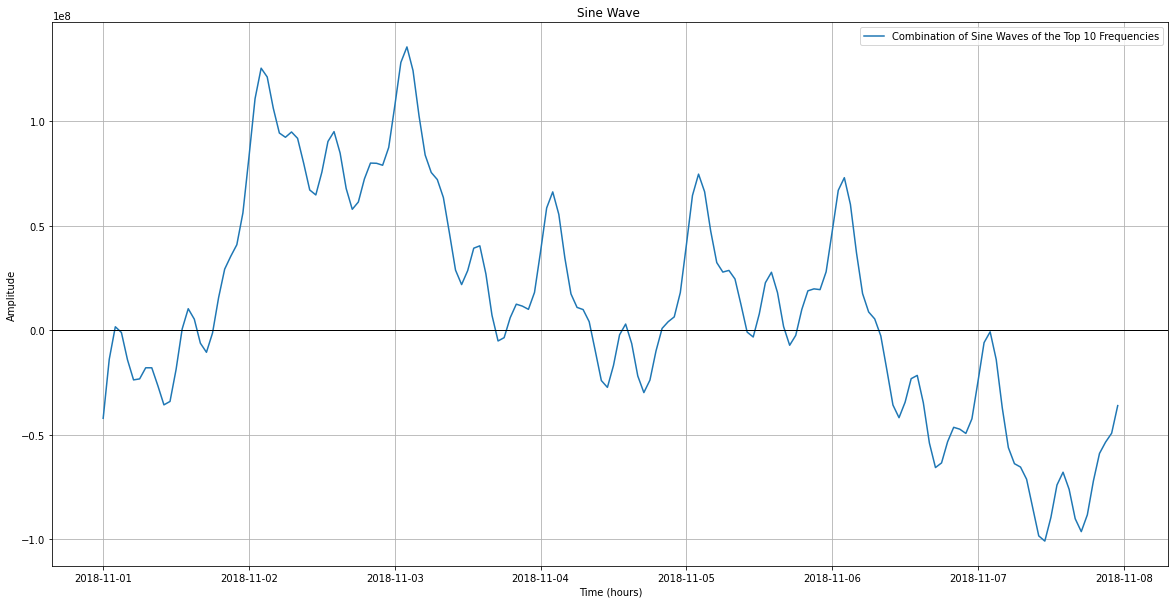

In [11]:
# PLot the combination for the first week of the data frame
import numpy as np
import matplotlib.pyplot as plt


# Plot the sine wave
plt.figure(figsize=(20, 10))
plt.plot(df.index[0:168], df['combined_sin'][0:168], label="Combination of Sine Waves of the Top 10 Frequencies")
plt.title('Sine Wave ')
plt.xlabel('Time (hours)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.axhline(0, color='black',linewidth=1)
plt.legend()
plt.show()

The combination of the sine waves does not catch the typical pattern of the load data.
The large spike during daytime is missing, as well as the two spikes around noon. The values are highest on November 2nd and 3rd 2018, which were a Friday and Saturday. This is untypical, because the values within a week are usually the lowest on Saturday and Sunday.

## Dominant Frequencies

<b>In the following, we want to find the frequencies with the highest amplitudes, ranked by their absolute values </b>

In [12]:
# Extract dominant frequencies and their amplitudes
dominant_freqs = freqs[np.argsort(np.abs(spectrum))[:10]]  # Top 10 frequencies
dominant_amplitudes = np.abs(spectrum)[np.argsort(np.abs(spectrum))[:10]]  # Corresponding amplitudes

# Add these as new columns in the dataframe for modeling
df['freq_1'] = dominant_freqs[0]
df['amp_1'] = dominant_amplitudes[0]
df['freq_2'] = dominant_freqs[1]
df['amp_2'] = dominant_amplitudes[1]
df['freq_3'] = dominant_freqs[2]
df['amp_3'] = dominant_amplitudes[2]
df['freq_4'] = dominant_freqs[3]
df['amp_4'] = dominant_amplitudes[3]
df['freq_5'] = dominant_freqs[4]
df['amp_5'] = dominant_amplitudes[4]
df['freq_6'] = dominant_freqs[5]
df['amp_6'] = dominant_amplitudes[5]
df['freq_7'] = dominant_freqs[6]
df['amp_7'] = dominant_amplitudes[6]
df['freq_8'] = dominant_freqs[7]
df['amp_8'] = dominant_amplitudes[7]
df['freq_9'] = dominant_freqs[8]
df['amp_9'] = dominant_amplitudes[8]
df['freq_10'] = dominant_freqs[9]
df['amp_10'] = dominant_amplitudes[9]



print(df.head())

                         load  price  biomass    water  offshore   onshore  \
time                                                                         
2018-11-01 00:00:00  48879.50  40.86  4754.75  1583.00   2721.00  11628.50   
2018-11-01 01:00:00  47312.50  41.10  4741.25  1587.50   2678.00  11029.00   
2018-11-01 02:00:00  46093.75  40.59  4733.25  1567.50   2836.75  11025.00   
2018-11-01 03:00:00  46710.50  40.09  4725.25  1550.00   2968.50  10480.25   
2018-11-01 04:00:00  47624.25  39.11  4715.00  1535.75   2765.25  10871.25   

                     solar  other_renewable  nuclear   lignite  ...    freq_6  \
time                                                            ...             
2018-11-01 00:00:00    0.0           153.00   7933.0  16108.75  ... -0.239653   
2018-11-01 01:00:00    0.0           153.00   7933.5  16119.00  ... -0.239653   
2018-11-01 02:00:00    0.0           153.00   7927.0  16111.00  ... -0.239653   
2018-11-01 03:00:00    0.0           152.50   79

### Convert dominant frequencies and amplitudes to sin waves and add them to the dataset

In [15]:
# Calculate sine waves and add their values to the dataset as new columns.

df['sin_wave_1'] = dominant_amplitudes[0] * np.sin(2 * np.pi * dominant_freqs[0] * df['hour'])
df['sin_wave_2'] = dominant_amplitudes[1] * np.sin(2 * np.pi * dominant_freqs[1] * df['hour'])
df['sin_wave_3'] = dominant_amplitudes[2] * np.sin(2 * np.pi * dominant_freqs[2] * df['hour'])
df['sin_wave_4'] = dominant_amplitudes[3] * np.sin(2 * np.pi * dominant_freqs[3] * df['hour'])
df['sin_wave_5'] = dominant_amplitudes[4] * np.sin(2 * np.pi * dominant_freqs[4] * df['hour'])
df['sin_wave_6'] = dominant_amplitudes[5] * np.sin(2 * np.pi * dominant_freqs[5] * df['hour'])
df['sin_wave_7'] = dominant_amplitudes[6] * np.sin(2 * np.pi * dominant_freqs[6] * df['hour'])
df['sin_wave_8'] = dominant_amplitudes[7] * np.sin(2 * np.pi * dominant_freqs[7] * df['hour'])
df['sin_wave_9'] = dominant_amplitudes[8] * np.sin(2 * np.pi * dominant_freqs[8] * df['hour'])
df['sin_wave_10'] = dominant_amplitudes[9] * np.sin(2 * np.pi * dominant_freqs[9] * df['hour'])


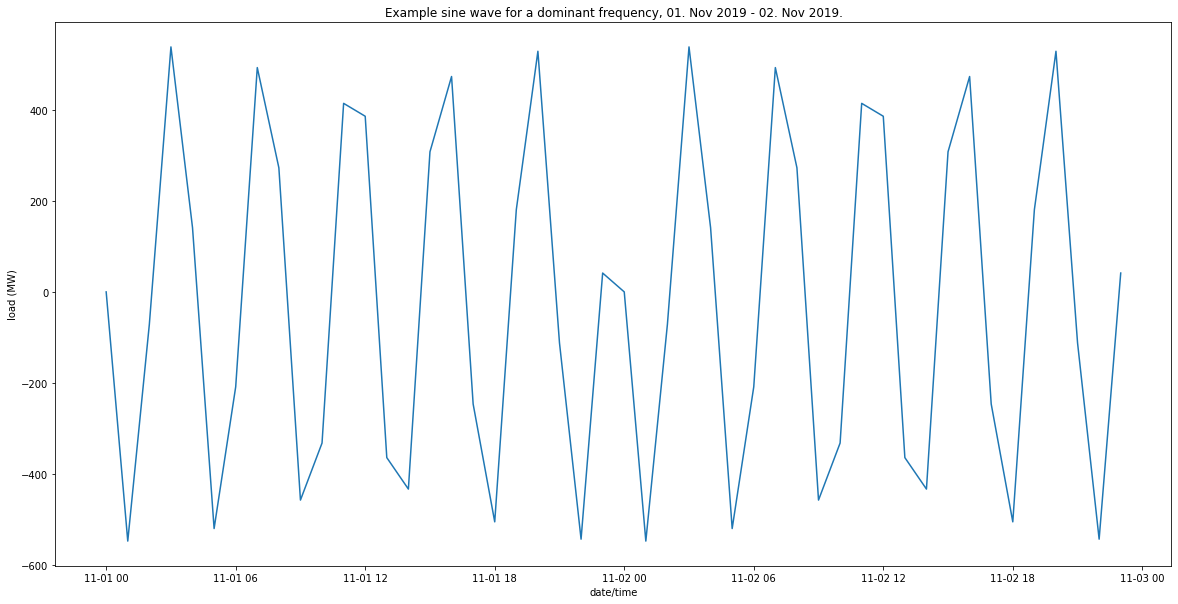

In [19]:
# Plot one of the sine waves as an example
# Plot for two days

# 48 samples = 48 hours = 2 days
df_days = df.iloc[:48]

plt.figure(figsize=(20, 10))
plt.plot(df_days.index, df_days['sin_wave_6'])

plt.title('Example sine wave for a dominant frequency, 01. Nov 2019 - 02. Nov 2019.')
plt.xlabel('date/time')
plt.ylabel('load (MW)')
plt.show()

The plot for the example sine wave shows a very similar pattern for the two days. It could stand for a oeriodicity of 1 day.

## Train / Test split

Repeat train test splitting after adding sin waves to the complete dataset.

In [21]:
# Check for the range of the data to verify the time span
print(df.index.min(), df.index.max())  # Should show range from Nov 1st, 2018 to Oct 31st, 2024

# Split the data into training and test sets (5:1 years)
train_size = int(0.83296 * len(df))
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Check the size of the splits
print(f"Training data from {train.index.min()} to {train.index.max()}")
print(f"Testing data from {test.index.min()} to {test.index.max()}")


2018-11-01 00:00:00 2024-10-30 23:00:00
Training data from 2018-11-01 00:00:00 to 2023-10-30 23:00:00
Testing data from 2023-10-31 00:00:00 to 2024-10-30 23:00:00


## Prediction

After getting the data about the spectral data, converting it to sine waves and adding them to the dataset, we want to use them for making predictions.

### ARIMAX without spectral data 

First, we train an ARIMAX model without the spectral data, to compare the results later and find out, if using the spectral data improves performance.

The data has several obvious seasonalities (yearly, weekly, daily). The information about those "seasons" is already included in the dataset as columns 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'dayofyear_sin' and 'dayofyear_cos'. They can be given to the ARIMA model as exogenous regressors. Therefore, it is not necessary to use a SARIMA model and train it for a certain seasonality.

In [27]:
%%time

from statsmodels.tsa.arima.model import ARIMA

# Define the features (including spectral and external variables)
exog_features = df[['price', 'biomass', 'water', 'offshore', 'onshore', 'solar', 'other_renewable',
                     'nuclear', 'lignite', 'coal', 'gas', 'pumped', 'other_conv', 
                     'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 
                     'month_cos', 'dayofyear_sin', 'dayofyear_cos']]


X_train, y_train = train[exog_features.columns], train['load']
X_test, y_test = test[exog_features.columns], test['load']

# Train an ARIMAX model (adjust p, d, q for ARIMA order)
model = ARIMA(y_train, exog=X_train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast on the test data
forecast = model_fit.forecast(steps=len(X_test), exog=X_test)

c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed 

Wall time: 1min 54s


c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


### Evaluation

In [29]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, forecast)
print(f'MAPE: {mape:.4f}')

# Calculate MAE
mae = mean_absolute_error(y_test, forecast)
print(f'MAE: {mae:.4f}')

MAPE: 0.5441
MAE: 27845.5655


The MAPE and MAE values are very high.

### Plot

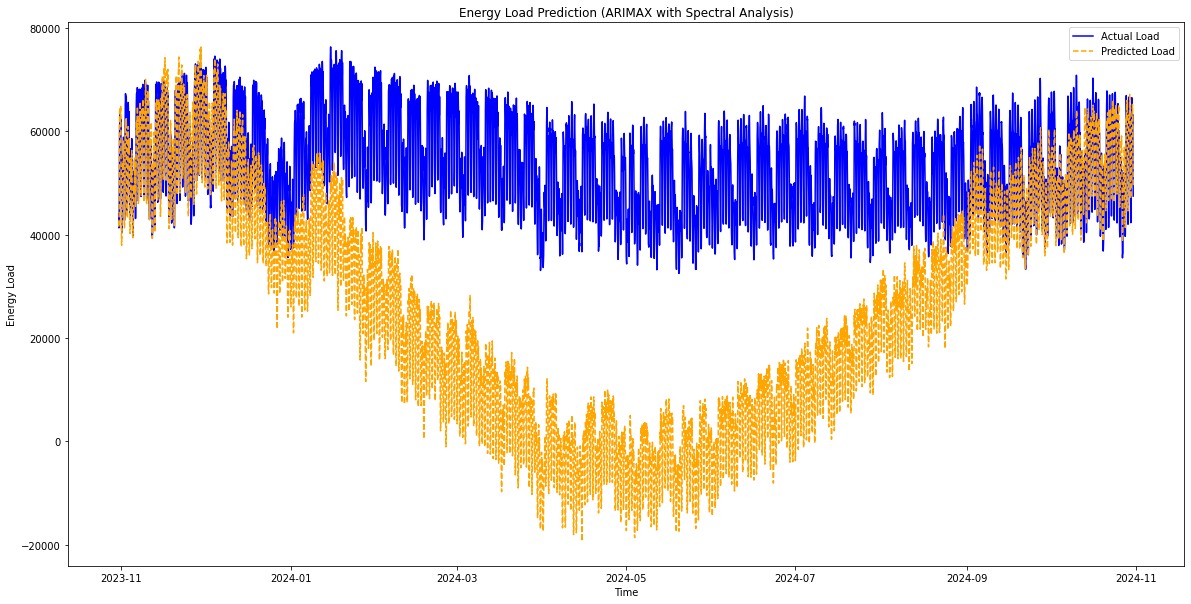

In [30]:
# Plot actual vs predicted energy load for one year (the test data)
plt.figure(figsize=(20, 10))
plt.plot(test.index, y_test, color='blue', label='Actual Load')
plt.plot(test.index, forecast, color='orange', label='Predicted Load', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

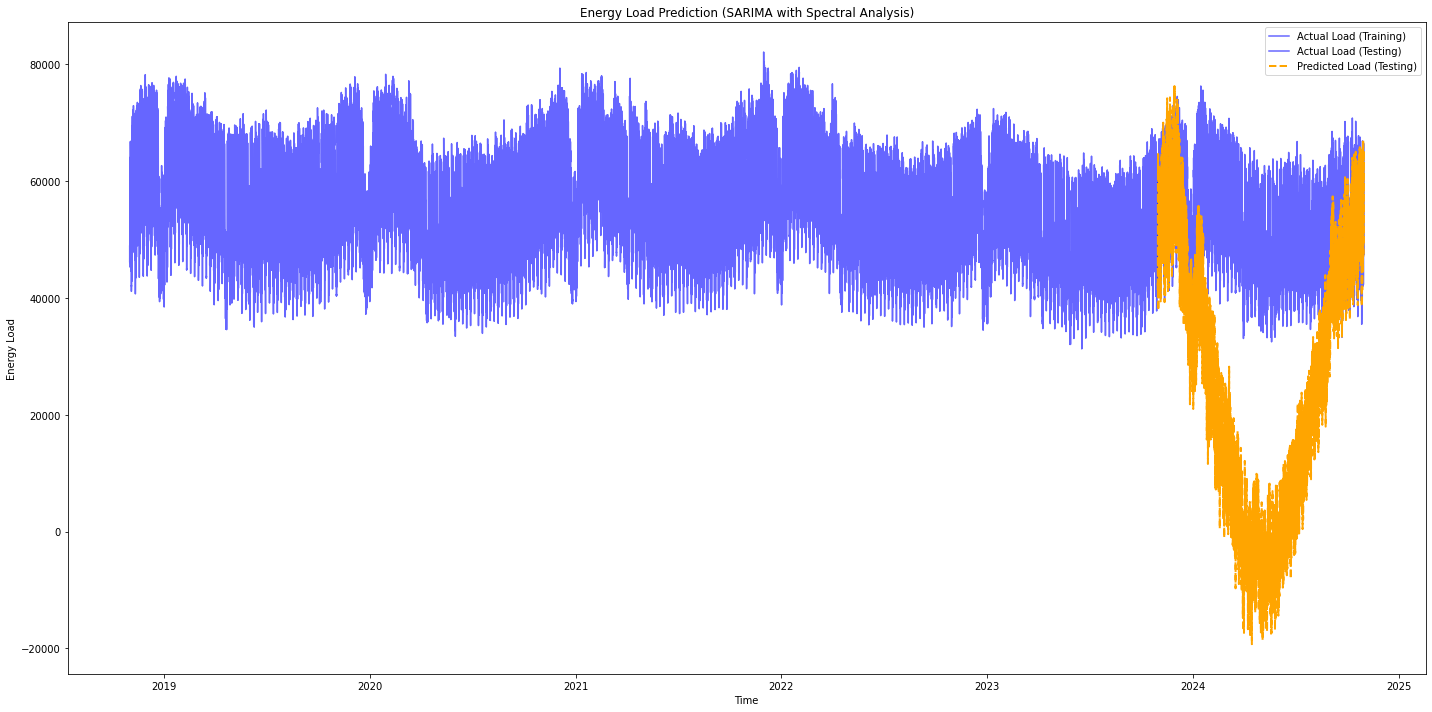

In [31]:
# Plot actual vs predicted energy load for the whole dataset (train + test) and predictions
plt.figure(figsize=(20, 10))

# Plot the actual load for the training and testing set
plt.plot(df.index[:train_size], y_train, label='Actual Load (Training)', color='blue', alpha=0.6)
plt.plot(df.index[train_size:], y_test, label='Actual Load (Testing)', color='blue', alpha=0.6)

# Plot the predicted load (only for the test period)
plt.plot(test.index, forecast, label='Predicted Load (Testing)', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (SARIMA with Spectral Analysis)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The results of this configuration are really off, especially when looking at the whole dataset in the second figure.

## ARIMAX with spectral data

The next experiment will include the spectral data in the exogenous regressors, instead of the previous exogenous regressors. Here, we use the sine waves generated from the dominant frequencies.

In [32]:
%%time

from statsmodels.tsa.arima.model import ARIMA

# Define the features (including spectral variables)
exog_features = df[['sin_wave_1', 'sin_wave_2', 'sin_wave_3', 'sin_wave_4', 'sin_wave_5', 'sin_wave_6', 'sin_wave_7', 'sin_wave_8', 'sin_wave_9', 'sin_wave_10']]


X_train, y_train = train[exog_features.columns], train['load']
X_test, y_test = test[exog_features.columns], test['load']

# Train an ARIMAX model (adjust p, d, q for ARIMA order)
model = ARIMA(y_train, exog=X_train, order=(2, 0, 2))
model_fit = model.fit()

# Forecast on the test data
forecast = model_fit.forecast(steps=len(X_test), exog=X_test)


c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed 

Wall time: 26.8 s


c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


### Evaluation

In [33]:

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, forecast)
print(f'MAPE: {mape:.4f}')

# Calculate MAE
mae = mean_absolute_error(y_test, forecast)
print(f'MAE: {mae:.4f}')

MAPE: 0.1680
MAE: 8175.1058


The MAPE and MAE are much better tha in the experiment above without using sine waves. But they are still not very good.

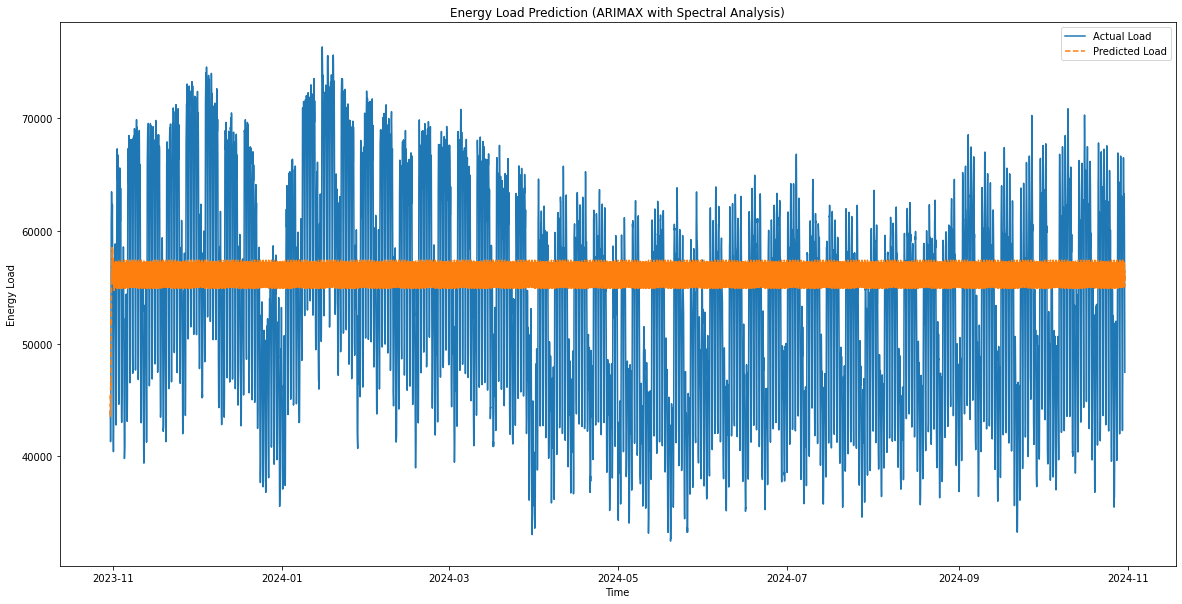

In [34]:
# Plot actual vs predicted energy load
plt.figure(figsize=(20, 10))
plt.plot(test.index, y_test, label='Actual Load')
plt.plot(test.index, forecast, label='Predicted Load', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

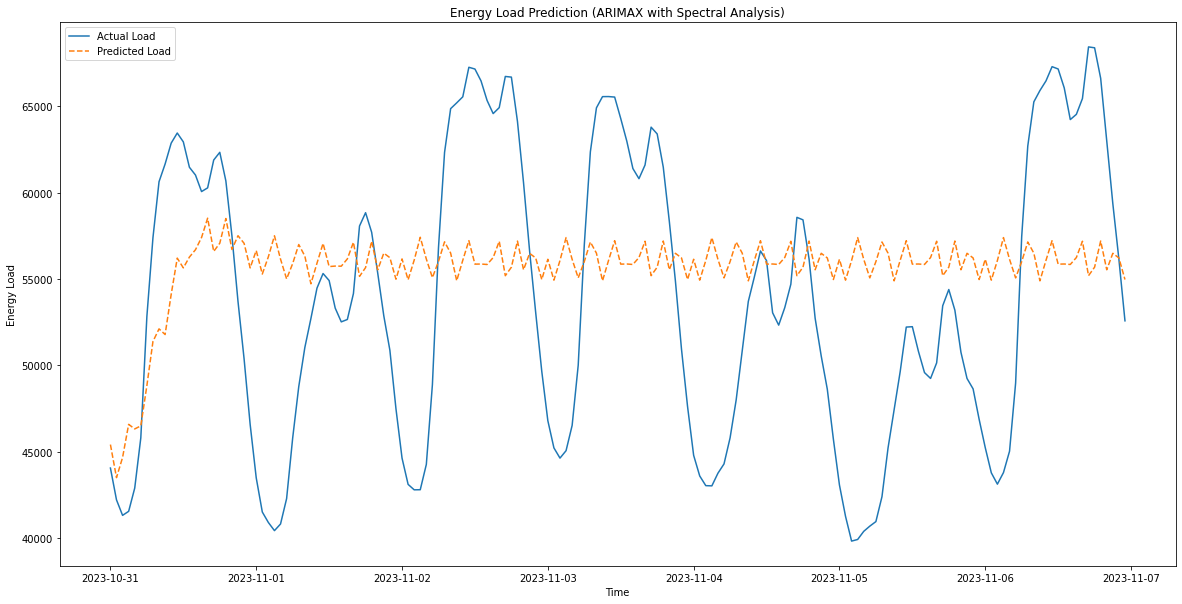

In [35]:
#Plot only one week


start = 0
end = 168

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = y_test[start:end]
forecast_section = forecast[start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, forecast_section, label='Predicted Load', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()


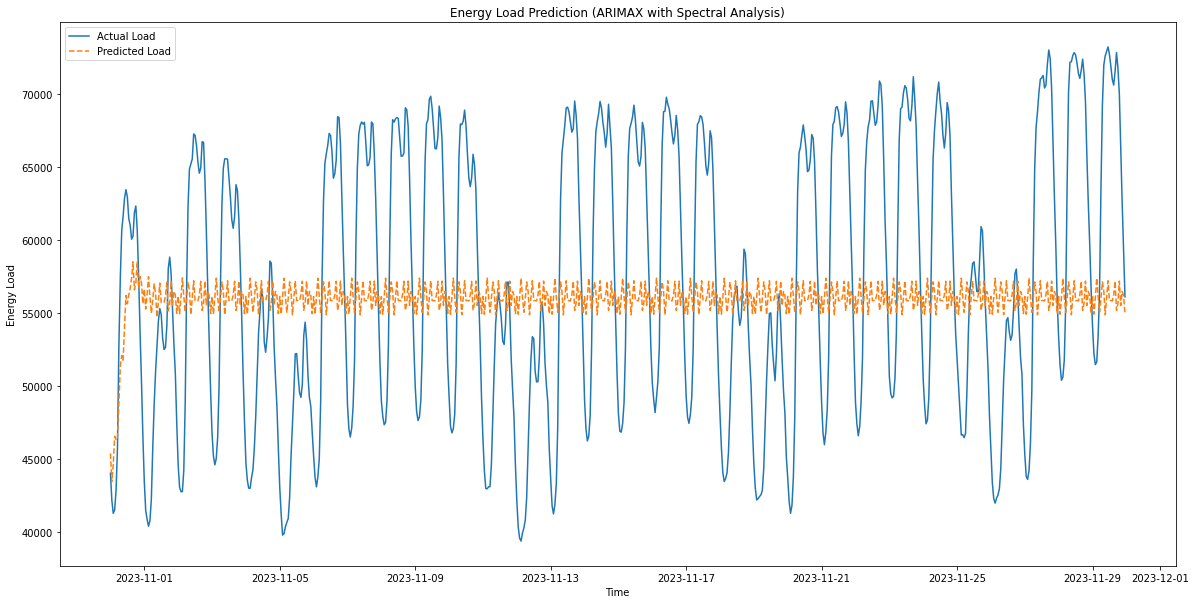

In [36]:
#Plot only one month
start = 0
end = 720

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = y_test[start:end]
forecast_section = forecast[start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, forecast_section, label='Predicted Load', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

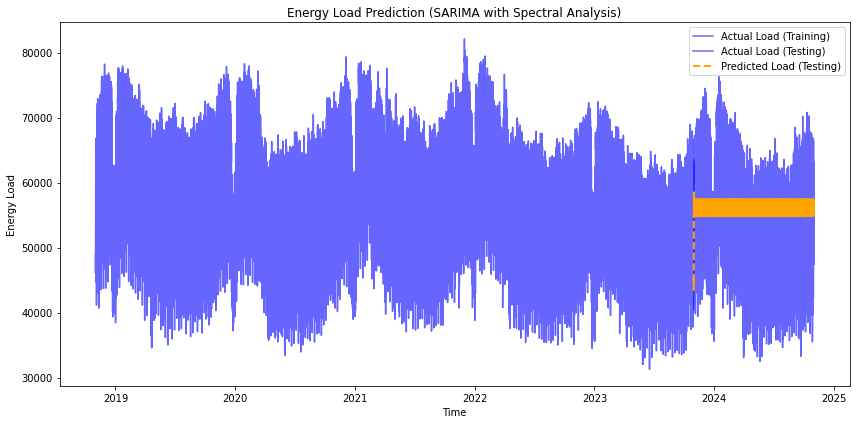

In [37]:
# Plot actual vs predicted energy load for the whole dataset (train + test) and predictions
plt.figure(figsize=(12, 6))

# Plot the actual load for the training and testing set
plt.plot(df.index[:train_size], y_train, label='Actual Load (Training)', color='blue', alpha=0.6)
plt.plot(df.index[train_size:], y_test, label='Actual Load (Testing)', color='blue', alpha=0.6)

# Plot the predicted load (only for the test period)
plt.plot(test.index, forecast, label='Predicted Load (Testing)', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (SARIMA with Spectral Analysis)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The plots above show that the predictions are missing the most relevant patterns. The daily, weekly and yearly seasonalities of the dataset cannot be detected.

## ARIMAX with sin_x (sine waves from top frequencies by complex amplitudes)

In the following, we repeat the experiment above, just using the sine waves derived from the top frequencies by complex amplitudes, we calculated above.

In [38]:
%%time

from statsmodels.tsa.arima.model import ARIMA

# Define the features (including spectral variables)
exog_features = df[['sin_1', 'sin_2', 'sin_3', 'sin_4', 'sin_5', 'sin_6', 'sin_7', 'sin_8', 'sin_9', 'sin_10']]


X_train, y_train = train[exog_features.columns], train['load']
X_test, y_test = test[exog_features.columns], test['load']

# Train an ARIMAX model (adjust p, d, q for ARIMA order)
model = ARIMA(y_train, exog=X_train, order=(2, 0, 2))
model_fit = model.fit()

# Forecast on the test data
forecast = model_fit.forecast(steps=len(X_test), exog=X_test)

c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Wall time: 17.9 s


c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [39]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, forecast)
print(f'MAPE: {mape:.4f}')

# Calculate MAE
mae = mean_absolute_error(y_test, forecast)
print(f'MAE: {mae:.4f}')

MAPE: 0.1689
MAE: 8225.9601


The results are similar as for the sine waves generated from dominant frequencies.

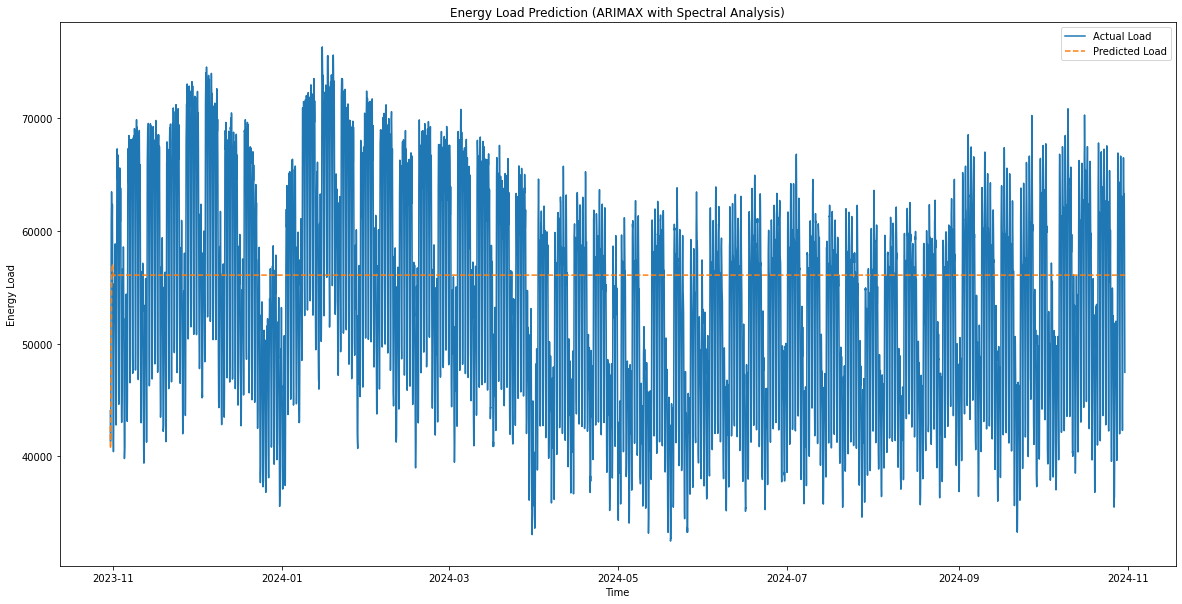

In [40]:
# Plot actual vs predicted energy load for whole test data
plt.figure(figsize=(20, 10))
plt.plot(test.index, y_test, label='Actual Load')
plt.plot(test.index, forecast, label='Predicted Load', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

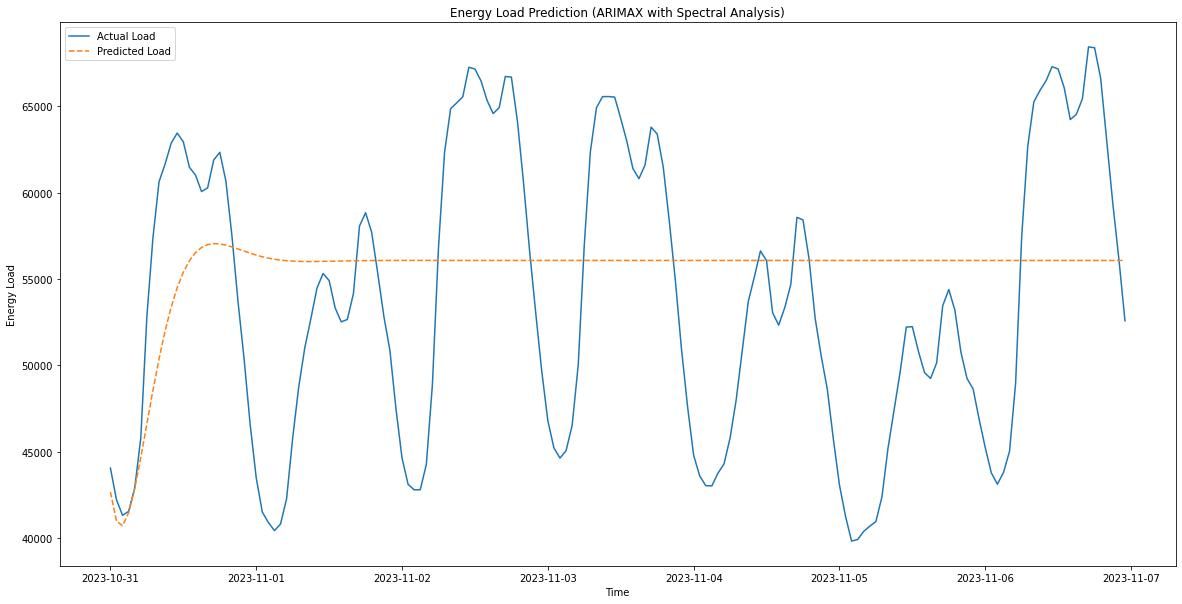

In [41]:
#Plot only one week

start = 0
end = 168

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = y_test[start:end]
forecast_section = forecast[start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, forecast_section, label='Predicted Load', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()


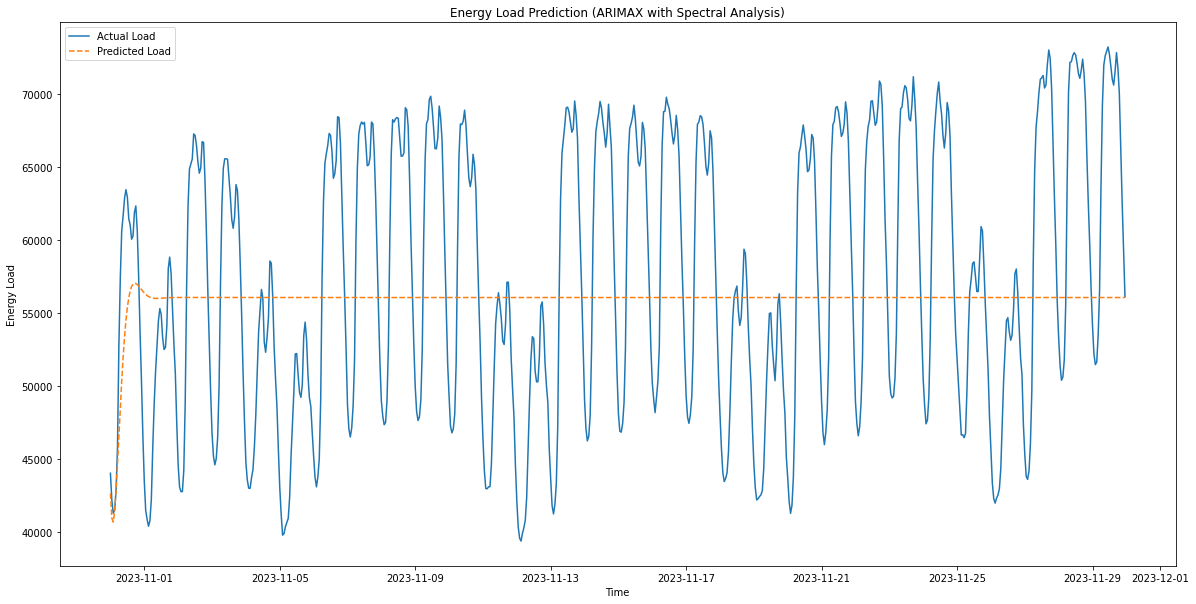

In [42]:
#Plot only one month
start = 0
end = 720

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = y_test[start:end]
forecast_section = forecast[start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, forecast_section, label='Predicted Load', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

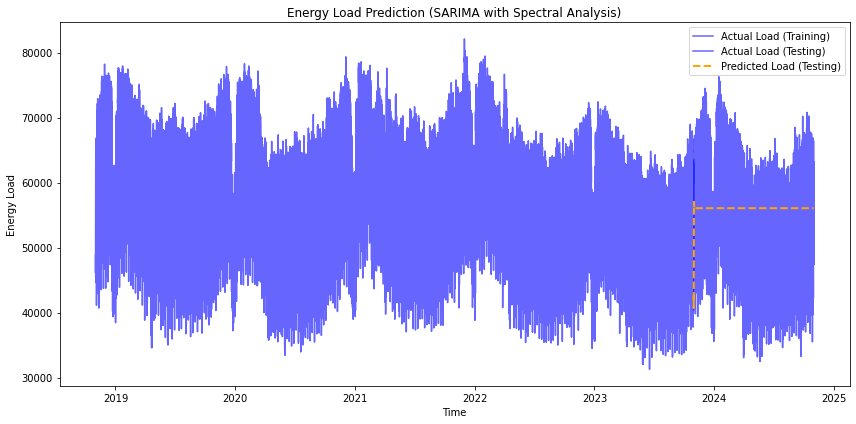

In [43]:
# Plot actual vs predicted energy load for the whole dataset (train + test) and predictions
plt.figure(figsize=(12, 6))

# Plot the actual load for the training and testing set
plt.plot(df.index[:train_size], y_train, label='Actual Load (Training)', color='blue', alpha=0.6)
plt.plot(df.index[train_size:], y_test, label='Actual Load (Testing)', color='blue', alpha=0.6)

# Plot the predicted load (only for the test period)
plt.plot(test.index, forecast, label='Predicted Load (Testing)', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (SARIMA with Spectral Analysis)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The plots show, that the sine waves might not have had much influence on the predictions, since most of the prediction is a flat line.

## Manually find out, which of the 10 sin_x are important

The experiments above did not give the desired results. 

Since the seasonalities of the data seem to be very obvious for the human eye, we try to manually choose frequencies associated with those seasonalities to give them to the model for training. 

First, we plot the data to see, what the frequencies stand for.

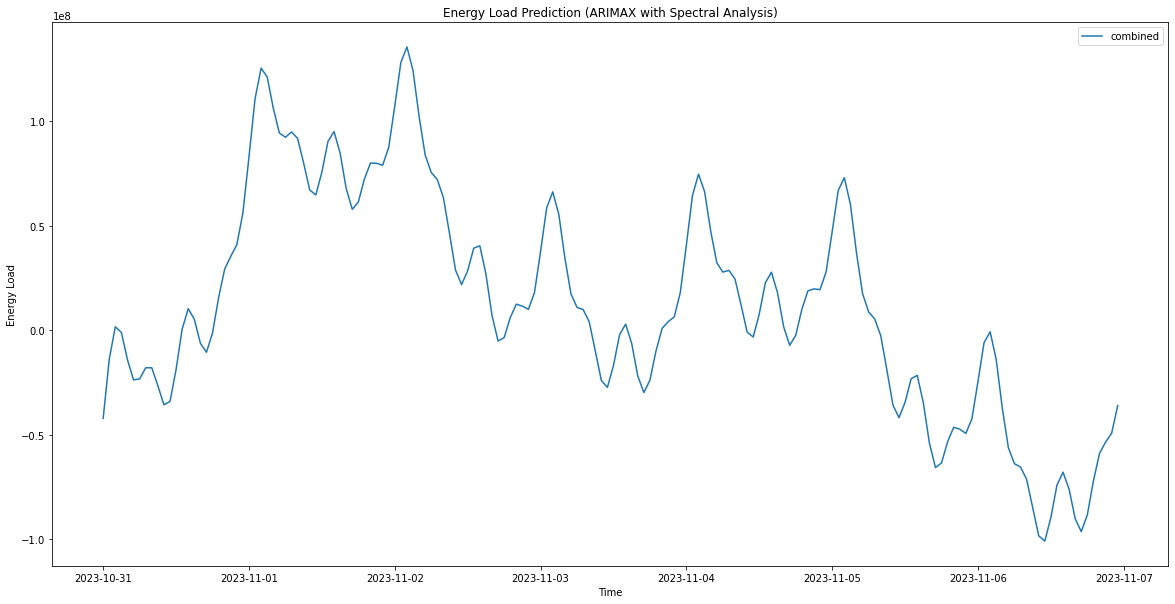

In [22]:
#Plot only one week


start = 0
end = 168

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = test['load'][start:end]
sin1 = test['sin_1'][start:end]
sin2 = test['sin_2'][start:end]
sin3 = test['sin_3'][start:end]
sin4 = test['sin_4'][start:end]
sin5 = test['sin_5'][start:end]
sin6 = test['sin_6'][start:end]
sin7 = test['sin_7'][start:end]
sin8 = test['sin_8'][start:end]
sin9 = test['sin_9'][start:end]
sin10 = test['sin_10'][start:end]
comb = test['combined_sin'][start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
#plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, comb, label='combined')
#plt.plot(section, sin1, label='sin 1')
#plt.plot(section, sin2, label='sin 2')
#plt.plot(section, sin3, label='sin 3')
#plt.plot(section, sin4, label='sin 4')
#plt.plot(section, sin5, label='sin 5')
#plt.plot(section, sin6, label='sin 6')
#plt.plot(section, sin7, label='sin 7')
#plt.plot(section, sin8, label='sin 8')
#plt.plot(section, sin9, label='sin 9')
#plt.plot(section, sin10, label='sin 10')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()


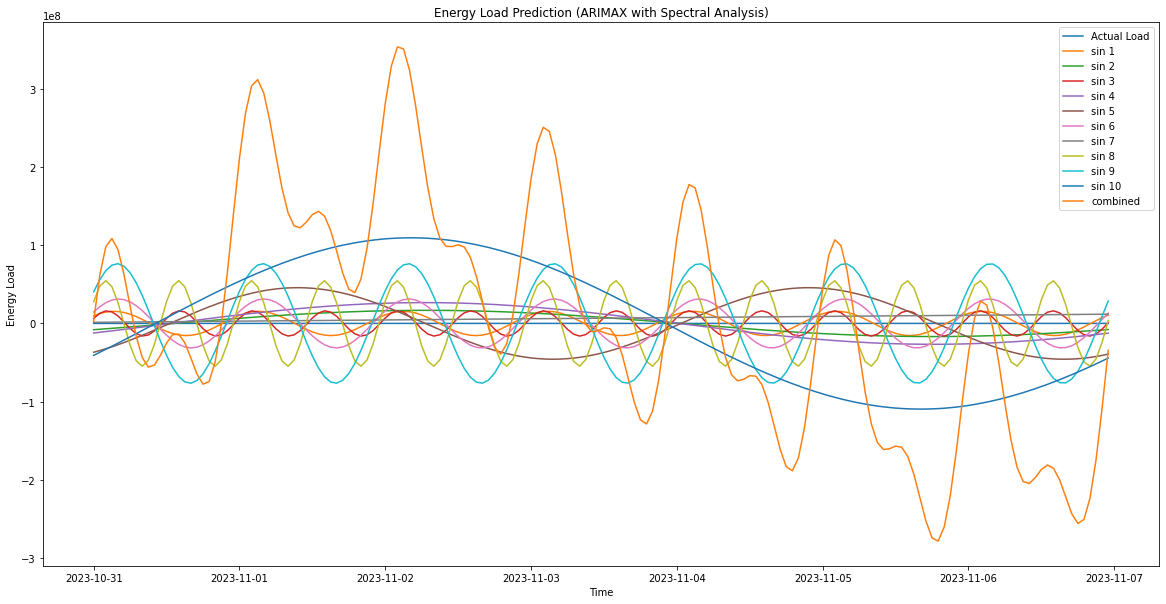

In [42]:

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, sin1, label='sin 1')
plt.plot(section, sin2, label='sin 2')
plt.plot(section, sin3, label='sin 3')
plt.plot(section, sin4, label='sin 4')
plt.plot(section, sin5, label='sin 5')
plt.plot(section, sin6, label='sin 6')
plt.plot(section, sin7, label='sin 7')
plt.plot(section, sin8, label='sin 8')
plt.plot(section, sin9, label='sin 9')
plt.plot(section, sin10, label='sin 10')
plt.plot(section, comb, label='combined')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()


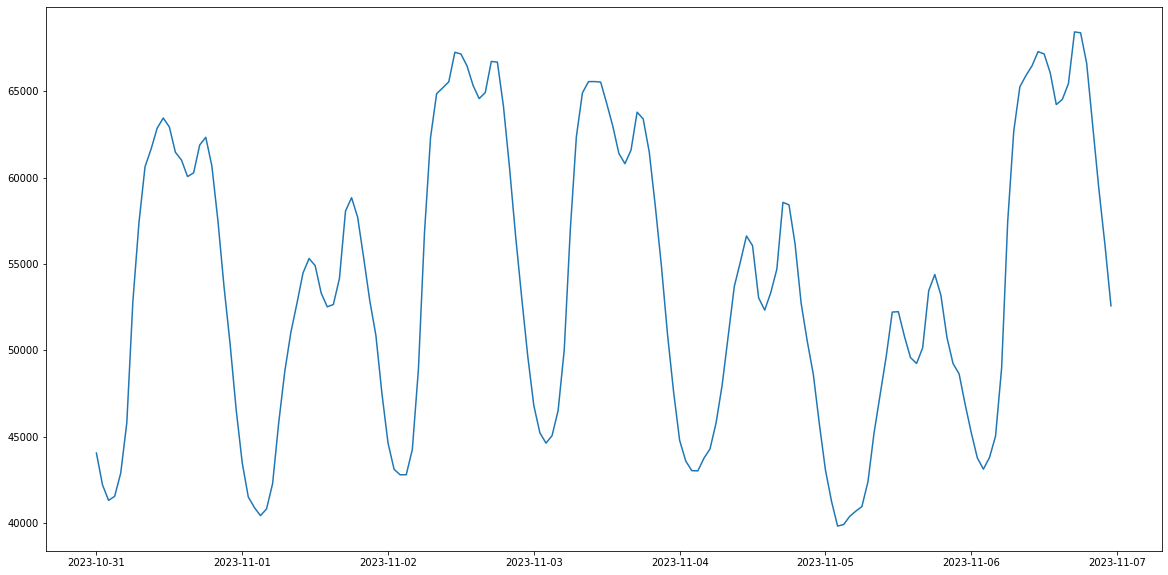

In [45]:
# Plot the true labels for comparison

plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.show()

We can see the different frequencies of the sine waves. 
The combination shows some of the patterns of the dataset: Low levels at night, higher levels during daytime. Also the two peaks before and after noon can be recognized, even though the second one is lower than it should be.

Following frequencies seem to be relevant for the seasonality:
 
 sin_1: 24 hours
 
 sin_5: 3.5 days
 
 sin_8: 12 hours
 
 sin_9: 24 hours
 
 sin_10: 1 week

## Training by using only limited number of specific sin waves

Keep only a few sin waves, representing:
 
 sin_1: 24 hours
 
 sin_5: 3.5 days
 
 sin_8: 12 hours
 
 sin_9: 24 hours
 
 sin_10: 1 week
 
The occurrence of two sin waves for 24 hours shall help recreating the two peaks before and after noon

Now, we add those hand-picked sine waves as exogenous features to the training.

In [55]:
%%time

from statsmodels.tsa.arima.model import ARIMA

# Define exogenous parameters
exog_features = df[['combined_sin', 'sin_1', 'sin_5', 'sin_8', 'sin_9', 'sin_10']]


X_train, y_train = train[exog_features.columns], train['load']
X_test, y_test = test[exog_features.columns], test['load']

# Train an ARIMAX model (adjust p, d, q for ARIMA order)
model = ARIMA(y_train, exog=X_train, order=(2, 0, 2))
model_fit = model.fit()

# Forecast on the test data
forecast = model_fit.forecast(steps=len(X_test), exog=X_test)

c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Wall time: 13.2 s


c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [56]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, forecast)
print(f'MAPE: {mape:.4f}')

# Calculate MAE
mae = mean_absolute_error(y_test, forecast)
print(f'MAE: {mae:.4f}')

MAPE: 0.1689
MAE: 8226.0305


The MAPE and MAE values don't show much difference to the experiments using sine waves above.

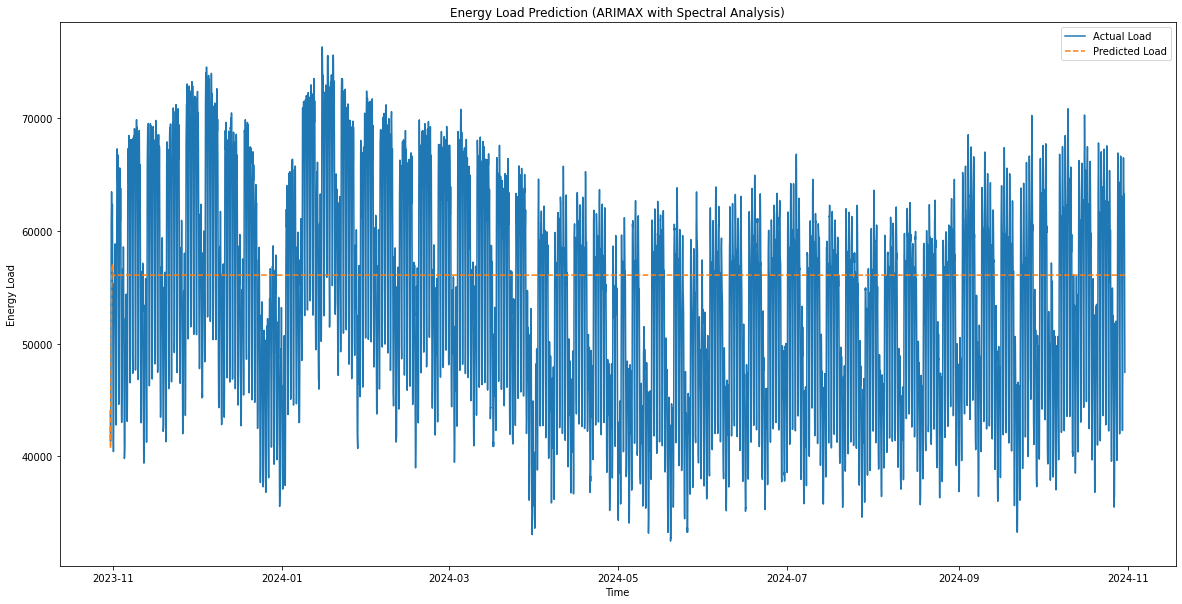

In [61]:
# Plot actual vs predicted energy load
plt.figure(figsize=(20, 10))
plt.plot(test.index, y_test, label='Actual Load')
plt.plot(test.index, forecast, label='Predicted Load', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

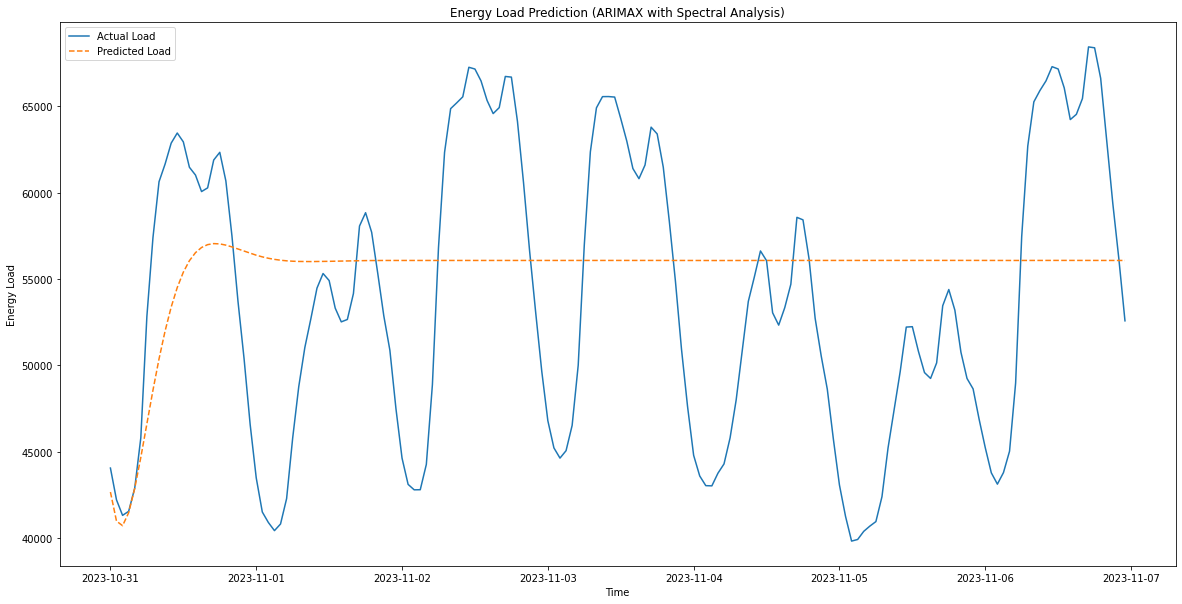

In [62]:
#Plot only one week


start = 0
end = 168

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = y_test[start:end]
forecast_section = forecast[start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, forecast_section, label='Predicted Load', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()


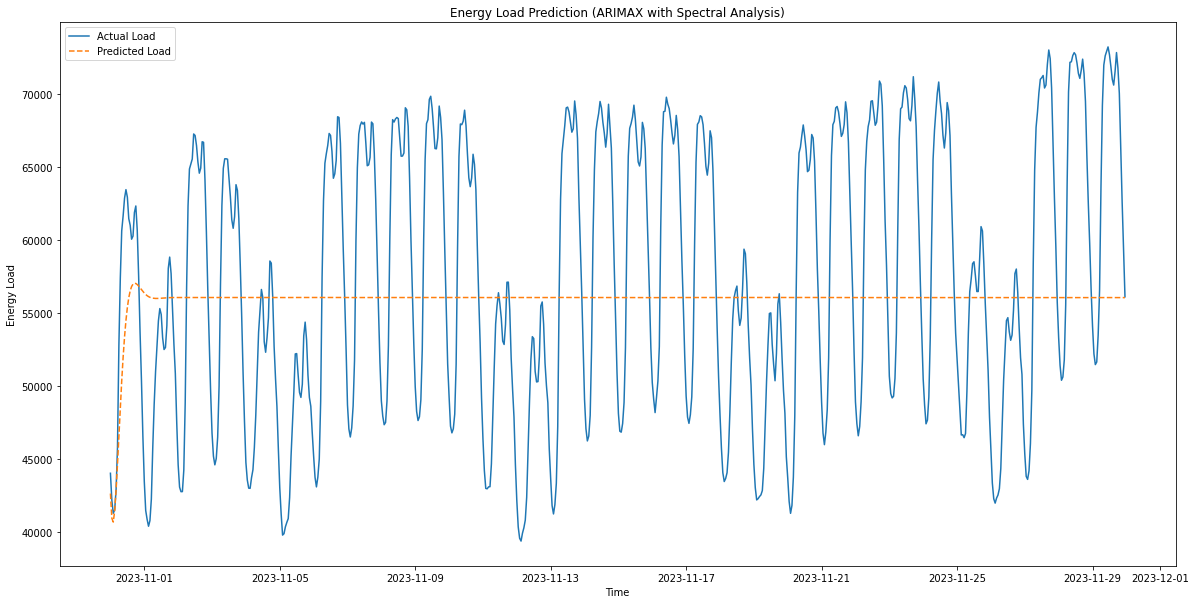

In [63]:
#Plot only one month
start = 0
end = 720

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = y_test[start:end]
forecast_section = forecast[start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, forecast_section, label='Predicted Load', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

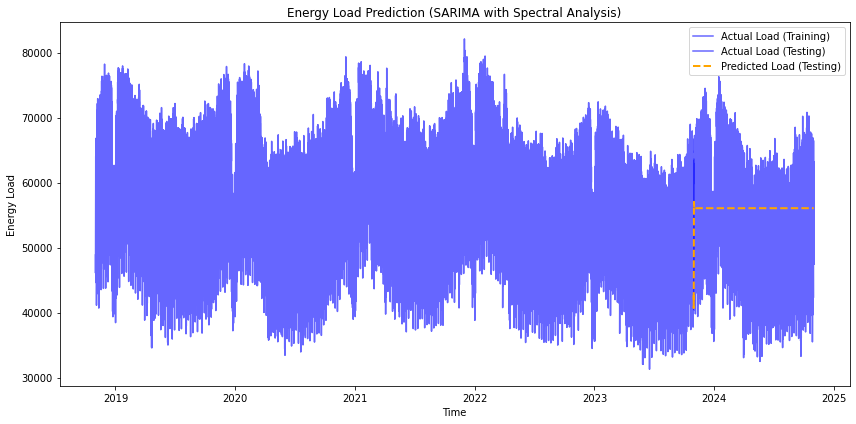

In [64]:
# Plot actual vs predicted energy load for the whole dataset (train + test) and predictions
plt.figure(figsize=(12, 6))

# Plot the actual load for the training and testing set
plt.plot(df.index[:train_size], y_train, label='Actual Load (Training)', color='blue', alpha=0.6)
plt.plot(df.index[train_size:], y_test, label='Actual Load (Testing)', color='blue', alpha=0.6)

# Plot the predicted load (only for the test period)
plt.plot(test.index, forecast, label='Predicted Load (Testing)', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (SARIMA with Spectral Analysis)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The plot shows a mainly flat line again. The training obviously did not catch the relevant seasonalities.

## Sine waves without phase: sine_x

Next, we want to find out, if the results get better, if we omit the information about the phase when creating the sine waves. 

Therefore, we create a new set of sine waves from the top 15 frequencies, this time without using a phase.

We also create a combination of the sine waves by summing them up, just like we did above.

In [25]:
# Build 15 sin waves to represent those frequencies:

for i in range(15):
    df[f'sine_{i+1}'] = top_amplitudes[i] * np.sin(2 * np.pi * top_freqs[i] * np.arange(len(df)))
    
df['sine_sum'] = df[[f'sine_{i}' for i in range(1, 16)]].sum(axis=1)


### Another train / test split after adding the new columns

We have to create a new train/test split, because we just added new columns to the dataset.

In [89]:
# Check for the range of the data to verify the time span
print(df.index.min(), df.index.max())  # Should show range from Nov 1st, 2018 to Oct 31st, 2024

# Split the data into training and test sets (5:1 years)
train_size = int(0.83296 * len(df))
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Check the size of the splits
print(f"Training data from {train.index.min()} to {train.index.max()}")
print(f"Testing data from {test.index.min()} to {test.index.max()}")


2018-11-01 00:00:00 2024-10-30 23:00:00
Training data from 2018-11-01 00:00:00 to 2023-10-30 23:00:00
Testing data from 2023-10-31 00:00:00 to 2024-10-30 23:00:00


## Plot new data

Let's have a look at the new sine waves.

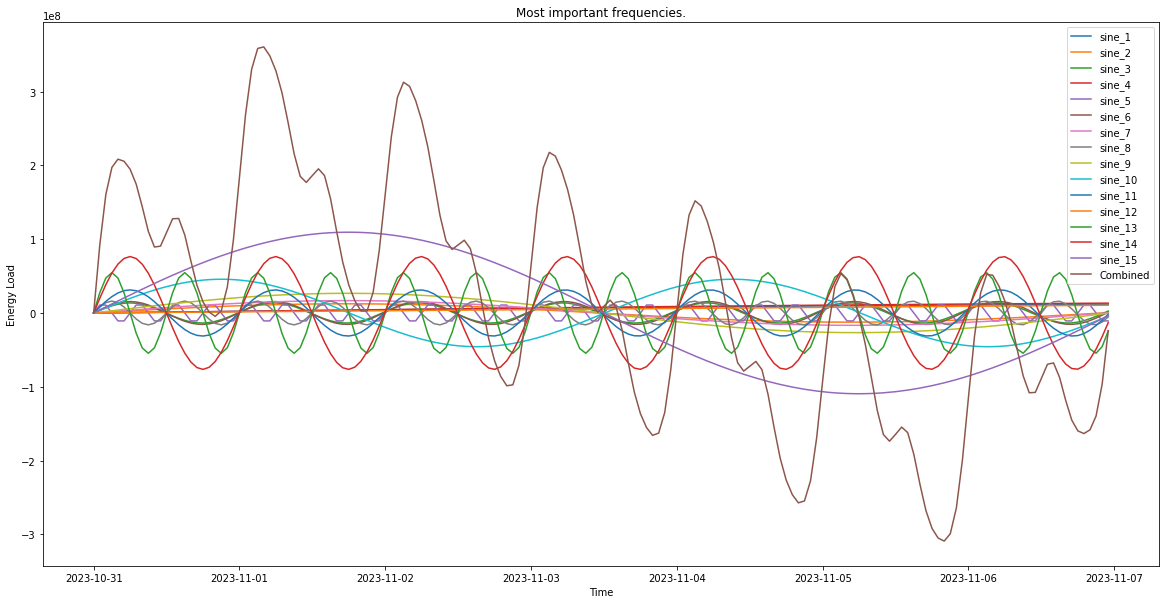

In [90]:
sectionl = test.index[:168]  # 168 hours in a week (24 hours * 7 days)
section = test.iloc[:168]  # First 168 rows of 'test'

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))

# Plot the sine waves (sine_1 to sine_15) for the first 168 rows
for i in range(1, 16):  # From sine_1 to sine_15
    plt.plot(sectionl, section[f'sine_{i}'], label=f'sine_{i}')

# Plot the combined prediction (only the first 168 rows of 'sine_sum')
plt.plot(sectionl, section['sine_sum'], label='Combined')

# Plot the actual load (only the first 168 rows of 'load')
#plt.plot(sectionl, section['load'], label='Actual Load')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Most important frequencies.')

# Show the legend
plt.legend()

# Show the plot
plt.show()


As above, we can recognize different seasonalities in the data, just like above. 

There are some clear daily waves like sine_4, a 3.5 day seasonality like in sine_10, a weekly pattern as in sine_5.

The combination shows a daily repetition and the two peaks around noon (with the second again being much lower).

## Training with sine waves without added phase

As above, the sine waves are given to the model as exogenous features.

In [91]:
%%time

from statsmodels.tsa.arima.model import ARIMA

# Define the features (including spectral variables)
exog_features = df[['sine_1', 'sine_2', 'sine_3', 'sine_4', 'sine_5', 'sine_6', 'sine_7', 'sine_8', 'sine_9', 'sine_10', 'sine_11', 'sine_12', 'sine_13', 'sine_14', 'sine_15']]


X_train, y_train = train[exog_features.columns], train['load']
X_test, y_test = test[exog_features.columns], test['load']

# Train an ARIMAX model (adjust p, d, q for ARIMA order)
model = ARIMA(y_train, exog=X_train, order=(2, 0, 2))
model_fit = model.fit()

# Forecast on the test data
forecast = model_fit.forecast(steps=len(X_test), exog=X_test)

c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Wall time: 21.4 s


c:\users\ich\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [92]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, forecast)
print(f'MAPE: {mape:.4f}')

# Calculate MAE
mae = mean_absolute_error(y_test, forecast)
print(f'MAE: {mae:.4f}')

MAPE: 0.1578
MAE: 7634.2403


The MAPE and MAE values are slightly better than before.

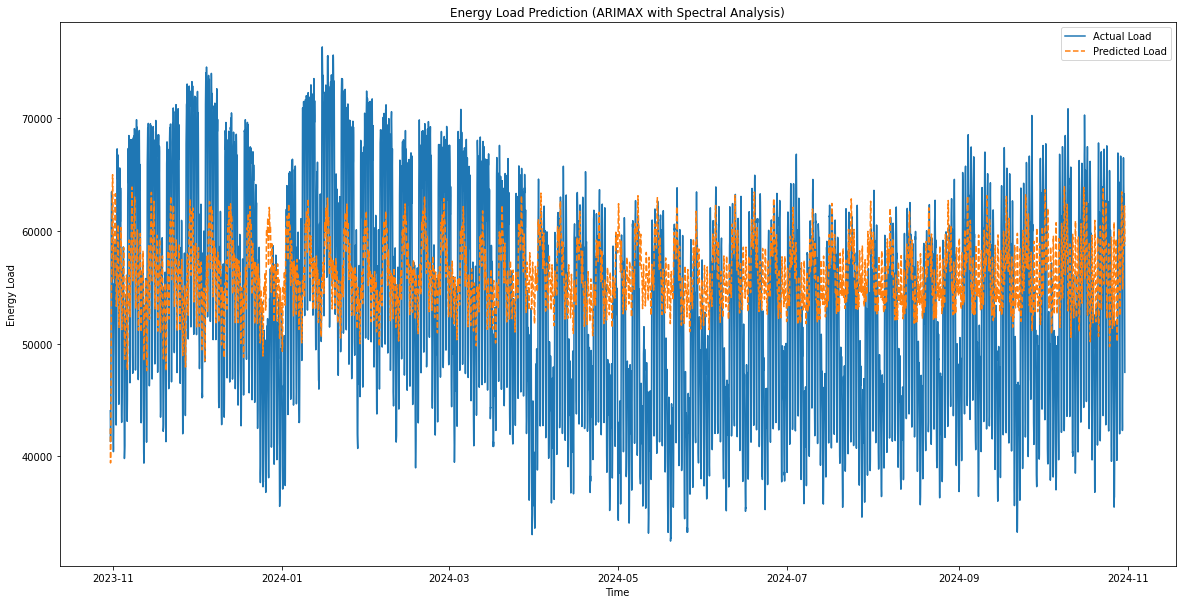

In [93]:
# Plot actual vs predicted energy load
plt.figure(figsize=(20, 10))
plt.plot(test.index, y_test, label='Actual Load')
plt.plot(test.index, forecast, label='Predicted Load', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

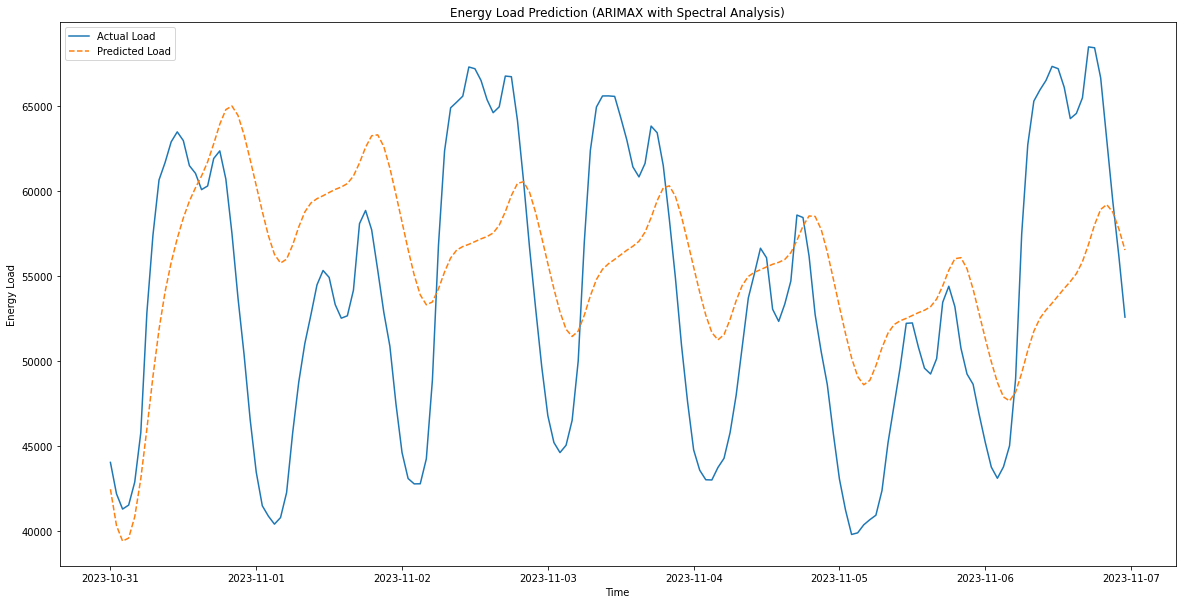

In [94]:
#Plot only one week


start = 0
end = 168

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = y_test[start:end]
forecast_section = forecast[start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, forecast_section, label='Predicted Load', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (ARIMAX with Spectral Analysis)')
plt.legend()
plt.show()


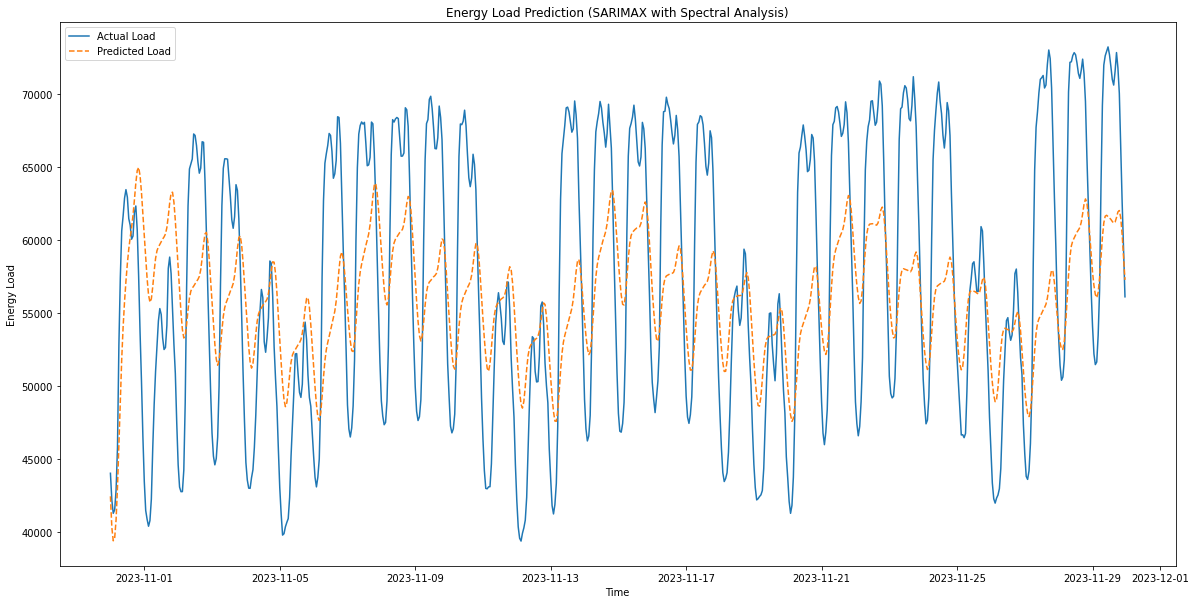

In [95]:
#Plot only one month
start = 0
end = 720

section = test.index[start:end]  # 168 hours in a week (24 hours * 7 days)

# Subset the data to the last week
y_test_section = y_test[start:end]
forecast_section = forecast[start:end]

# Plot actual vs predicted energy load for the last week
plt.figure(figsize=(20, 10))
plt.plot(section, y_test_section, label='Actual Load')
plt.plot(section, forecast_section, label='Predicted Load', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (SARIMAX with Spectral Analysis)')
plt.legend()
plt.show()

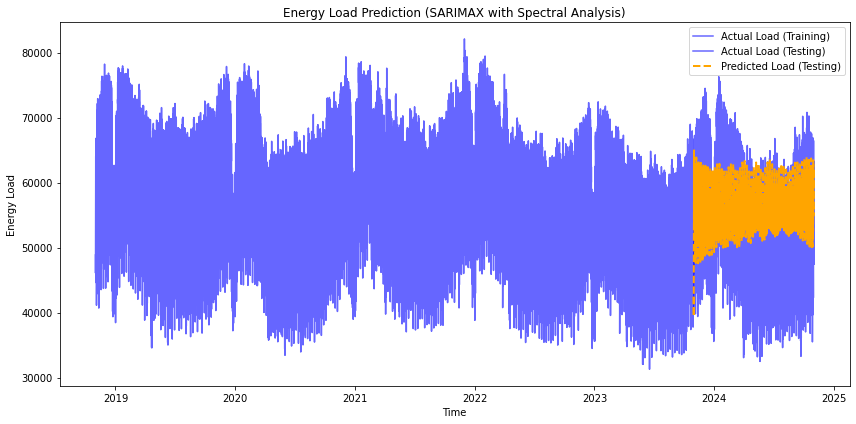

In [96]:
# Plot actual vs predicted energy load for the whole dataset (train + test) and predictions
plt.figure(figsize=(12, 6))

# Plot the actual load for the training and testing set
plt.plot(df.index[:train_size], y_train, label='Actual Load (Training)', color='blue', alpha=0.6)
plt.plot(df.index[train_size:], y_test, label='Actual Load (Testing)', color='blue', alpha=0.6)

# Plot the predicted load (only for the test period)
plt.plot(test.index, forecast, label='Predicted Load (Testing)', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Energy Load')
plt.title('Energy Load Prediction (SARIMAX with Spectral Analysis)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The plots show, that the model caught some of the relevant patterns / seasonalities. 

We have a daily pattern with two peaks around noon and low values at night.

We can also detect the weekly pattern with lower values on the weekend.

The yearly seasonality, in contrast, cannot be seen in the predictions

The prediction is so far the best we achieved with this method. The results are still quite off.